In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

(874, 1164, 3)
(H,W,3)= (874, 1164, 3)


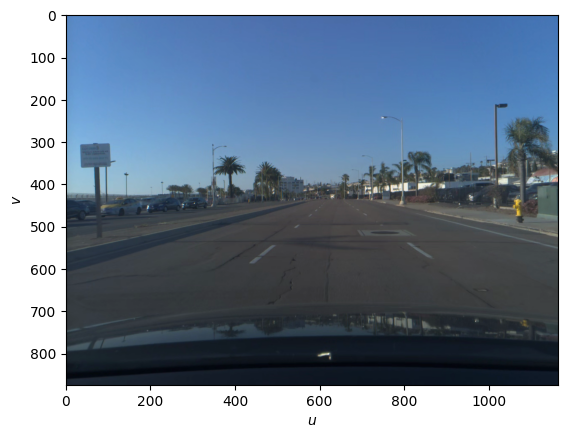

In [4]:
img_fn = str(Path("images/sample.png"))

img = cv2.imread(img_fn)[:, :, (2, 1, 0)]
print(img.shape)
# opencv (cv2) stores colors in the order blue, green, red, but we want red, green, blue
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.xlabel("$u$") # horizontal pixel coordinate
plt.ylabel("$v$") # vertical pixel coordinate

print("(H,W,3)=",img.shape)

In [ ]:
class LaneDetector():
    def __init__(self, cam_geom=CameraGeometry(), model_path='./fastai_model.pth'):
        self.cg = cam_geom
        self.cut_v, self.grid = self.cg.precompute_grid()
        if torch.cuda.is_available():
            self.device = "cuda"
            self.model = torch.load(model_path).to(self.device)
        else:
            self.model = torch.load(model_path, map_location=torch.device("cpu"))
            self.device = "cpu"
        self.model.eval()

    def read_imagefile_to_array(self, filename):
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image   

    def detect_from_file(self, filename):
        img_array = self.read_imagefile_to_array(filename)
        return self.detect(img_array)

    def _predict(self, img):
        with torch.no_grad():
            image_tensor = img.transpose(2,0,1).astype('float32')/255
            x_tensor = torch.from_numpy(image_tensor).to(self.device).unsqueeze(0)
            model_output = torch.softmax(self.model.forward(x_tensor), dim=1).cpu().numpy()
        return model_output

    def detect(self, img_array):
        model_output = self._predict(img_array)
        background, left, right = model_output[0,0,:,:], model_output[0,1,:,:], model_output[0,2,:,:] 
        return background, left, right

    def fit_poly(self, probs):
        probs_flat = np.ravel(probs[self.cut_v:, :])
        mask = probs_flat > 0.3
        if mask.sum() > 0:
            coeffs = np.polyfit(self.grid[:,0][mask], self.grid[:,1][mask], deg=3, w=probs_flat[mask])
        else:
            coeffs = np.array([0.,0.,0.,0.])
        return np.poly1d(coeffs)

    def __call__(self, image):
        if isinstance(image, str):
            image = self.read_imagefile_to_array(image)
        left_poly, right_poly, _, _ = self.get_fit_and_probs(image)
        return left_poly, right_poly

    def get_fit_and_probs(self, img):
        _, left, right = self.detect(img)
        left_poly = self.fit_poly(left)
        right_poly = self.fit_poly(right)
        return left_poly, right_poly, left, right


In [3]:
import sys, copy
sys.path.append('../../code')
from Algorithms-for-Automated-Driving.code.solutions.lane_detection.lane_detector import LaneDetector

model_path = "../../code/solutions/lane_detection/fastai_model.pth"
ld = LaneDetector(model_path=model_path)

array([221, 237, 253], dtype=uint8)

In [10]:
reading = np.array([])
f = open("labeled/0.txt", "r")
x = f.read()

In [17]:
x = x.split('\n')

In [18]:
x[0]

'3.346066188150387949e-02 3.149205029088487234e-02'